# Autoencoder programming 

In [1]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)


# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [2]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [3]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [4]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [6]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

(60000, 784)
(10000, 784)


In [7]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.3509 - val_loss: 0.2690
Epoch 2/50
60000/60000 [==============================] - 2s 25us/step - loss: 0.2601 - val_loss: 0.2484
Epoch 3/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.2383 - val_loss: 0.2265
Epoch 4/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.2188 - val_loss: 0.2092
Epoch 5/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.2041 - val_loss: 0.1968
Epoch 6/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.1936 - val_loss: 0.1878
Epoch 7/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.1855 - val_loss: 0.1804
Epoch 8/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.1787 - val_loss: 0.1742
Epoch 9/50
60000/60000 [==============================] - 2s 2

In [8]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

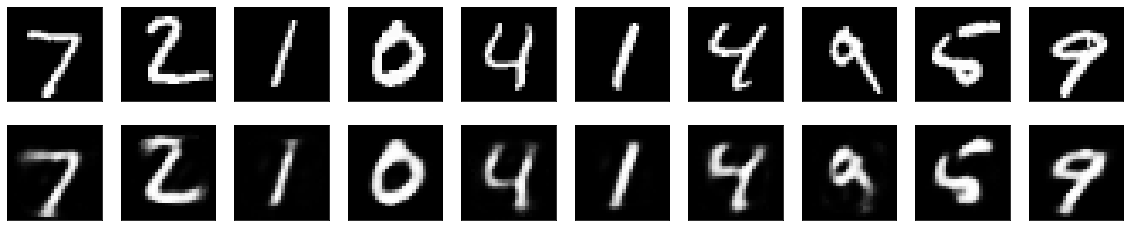

In [10]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Adding a sparsity constraint on the encoded representations
In the previous example, the representations were only constrained by the size of the hidden layer (32). In such a situation, what typically happens is that the hidden layer is learning an approximation of PCA (principal component analysis). But another way to constrain the representations to be compact is to add a sparsity contraint on the activity of the hidden representations, so fewer units would "fire" at a given time. In Keras, this can be done by adding an activity_regularizer to our Dense layer:

In [11]:
from keras import regularizers

encoding_dim = 32

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

# Deeper Autoencoder

In [12]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

# Convolutional Autoencoder

In [14]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [15]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))